In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('bank-full.csv', sep=";")

In [14]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [15]:
columns = ["age", "job", "marital", "education", "balance", "housing","contact", "day",
           "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

In [16]:
df_new = df[columns]
df_new.isnull().sum()

,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


**Вопрос 1**

**Какое самое частое значение (mode) для столбца education?**

In [17]:
df_new["education"].mode()

,education
0,secondary


***Ответ: secondary***

**Вопрос 2**

In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [19]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = df[numeric_columns].corr()

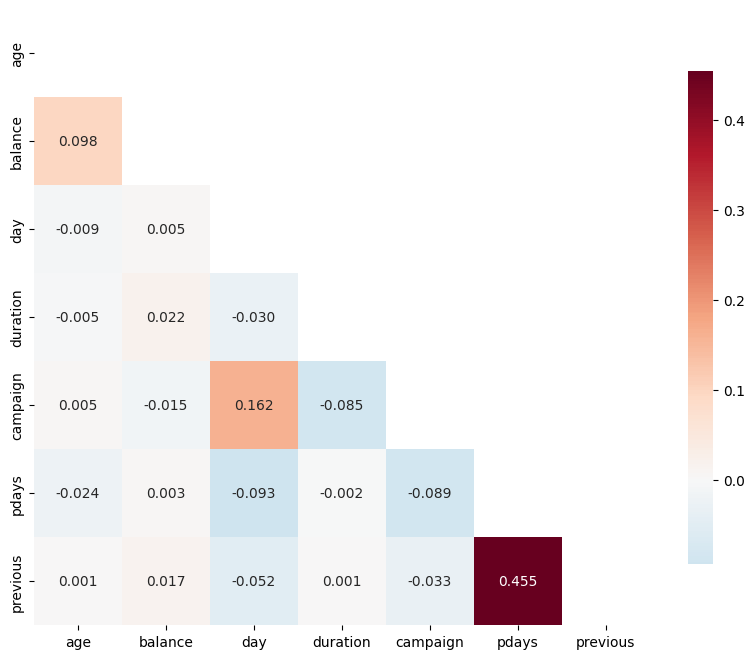

In [24]:
import seaborn as sns

plt.figure(figsize=(10,8))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Маска для верхнего треугольника
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.3f',
            square=True,
            cbar_kws={'shrink': 0.8})


plt.show()

In [25]:
corr_pairs = []
for i in range(len(numeric_columns)):
    for j in range(i+1, len(numeric_columns)):
        corr_pairs.append({
            'pair': f"{numeric_columns[i]} и {numeric_columns[j]}",
            'correlation': abs(correlation_matrix.iloc[i, j])
        })

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: x['correlation'], reverse=True)
print("Пары с наибольшей корреляцией:")
for pair in corr_pairs_sorted[:3]:
    print(f"{pair['pair']}: {pair['correlation']:.3f}")

Пары с наибольшей корреляцией:
pdays и previous: 0.455
day и campaign: 0.162
age и balance: 0.098


***Ответ: age и balance***

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_new['y'] = df_new['y'].map({'yes': 1, 'no': 0})

X = df_new.drop('y', axis=1)
y = df_new['y']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

/tmp/ipython-input-1849655354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['y'] = df_new['y'].map({'yes': 1, 'no': 0})


**Вопрос 3**

In [29]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

In [32]:
categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

mi_scores = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_col = le.fit_transform(X_train[col].fillna('missing'))

    mi = mutual_info_classif(encoded_col.reshape(-1, 1), y_train)[0]
    mi_scores[col] = round(mi, 2)

print("Взаимная информация:")
for col, score in sorted(mi_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {score}")

Взаимная информация:
poutcome: 0.03
month: 0.02
job: 0.01
housing: 0.01
contact: 0.01
marital: 0.0
education: 0.0


***Ответ: poutcome***

**Вопрос 4**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [36]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_val_encoded = pd.get_dummies(X_val, columns=categorical_columns)

missing_cols = set(X_train_encoded.columns) - set(X_val_encoded.columns)
for col in missing_cols:
    X_val_encoded[col] = 0
X_val_encoded = X_val_encoded[X_train_encoded.columns]

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)

y_val_pred = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Точность на валидации: {accuracy:.2f}")

Точность на валидации: 0.90


***Ответ: 0.90***

**Вопрос 5**

In [39]:
base_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Исходная точность: {base_accuracy:.3f}")

features_to_test = ['age', 'balance', 'marital', 'previous']
accuracy_differences = {}

for feature in features_to_test:
    X_train_reduced = X_train.drop(feature, axis=1)
    X_val_reduced = X_val.drop(feature, axis=1)

    X_train_reduced_encoded = pd.get_dummies(X_train_reduced, columns=[col for col in categorical_columns if col != feature])
    X_val_reduced_encoded = pd.get_dummies(X_val_reduced, columns=[col for col in categorical_columns if col != feature])

    missing_cols = set(X_train_reduced_encoded.columns) - set(X_val_reduced_encoded.columns)
    for col in missing_cols:
        X_val_reduced_encoded[col] = 0
    X_val_reduced_encoded = X_val_reduced_encoded[X_train_reduced_encoded.columns]

    model_reduced = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_reduced.fit(X_train_reduced_encoded, y_train)
    y_val_pred_reduced = model_reduced.predict(X_val_reduced_encoded)

    reduced_accuracy = accuracy_score(y_val, y_val_pred_reduced)
    difference = base_accuracy - reduced_accuracy
    accuracy_differences[feature] = difference
    print(f"Без {feature}: {reduced_accuracy:.3f}, разница: {difference}")

min_diff_feature = min(accuracy_differences, key=lambda x: abs(accuracy_differences[x]))
print(f"Наименьшая разница у признака: {min_diff_feature}")

Исходная точность: 0.901
Без age: 0.901, разница: 0.0
Без balance: 0.901, разница: 0.00044238000442387015
Без marital: 0.901, разница: 0.0
Без previous: 0.901, разница: 0.0005529750055297544
Наименьшая разница у признака: age


***Ответ: age***

**Вопрос 6**

In [43]:
C_values = [0.01, 0.1, 1, 10]
best_accuracy = 0
best_C = None

for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train)

    y_val_pred = model.predict(X_val_encoded)
    accuracy = accuracy_score(y_val, y_val_pred)

    print(f"C={C}: Точность = {accuracy:.3f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Лучшее C: {best_C} с точностью {best_accuracy:.3f}")

C=0.01: Точность = 0.898
C=0.1: Точность = 0.901
C=1: Точность = 0.901
C=10: Точность = 0.901
Лучшее C: 0.1 с точностью 0.901


***Ответ: C=0.1***

# Ответы на вопросы:

1) secondary
2) age и balance
3) poutcome
4) 0.90
5) age
6) C=0.1